# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV844"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv844')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv844/lv844-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 14:13:24,828 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
1894,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,844,0.801124,0.000126,0.001347


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP059039, SRP032789, SRP027015, SRP055569, SRP050892, SRP064464, SRP059643, SRP028336, SRP058181, SRP003726, SRP050499, SRP042161, SRP056477, SRP006970, SRP048759, SRP058237, SRP057196, SRP039397, SRP027258, SRP058722, SRP041538, SRP007412, SRP045639, SRP060416, SRP060355, SRP034634, SRP019241, SRP043378, SRP056295, SRP030628, SRP032989, SRP059733, SRP059775, SRP042620, SRP051606, SRP052491, SRP041825, SRP056604, SRP017942, SRP063840, SRP018719, SRP059732, SRP066834, SRP020493, SRP029367, SRP057852, SRP018359, SRP026042, SRP044668, SRP004837, SRP050493, SRP009266, SRP063834, SRP056049, SRP056074, SRP010430, SRP012015, SRP052615, SRP018778, SRP023270, SRP035417, SRP028594, SRP033135, SRP032775, SRP004847, SRP056835, SRP050223, SRP050272, SRP014540, SRP056733, SRP032812, SRP043434, SRP008218, SRP044042, SRP014213, SRP010038, SRP033266, SRP029880, SRP012461, SRP027364, SRP040300, SRP056840, SRP043417, SRP019936, SRP050000, SRP060715, SRP039591, SRP058571, SRP028301, SRP021130, SRP026537,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (90 != 91)
  warnings.warn(


In [19]:
lv_data.shape

(9532, 120)

In [20]:
lv_data.head()

age     group organisms  severity  \
project   run                                                             
SRP059039 SRR2049587  2 year-old or older   Control      EPEC   Control   
          SRR2049621  2 year-old or older  Diarrhea      DAEC      mild   
          SRR2049622  2 year-old or older  Diarrhea      DAEC      mild   
          SRR2049620          <2 year-old  Diarrhea      DAEC  moderate   
          SRR2049619          <2 year-old  Diarrhea      DAEC      mild   

                           tissue flowcell lane tumor type cycloheximide  \
project   run                                                              
SRP059039 SRR2049587  Whole blood        A    8        NaN           NaN   
          SRR2049621  Whole blood        A    6        NaN           NaN   
          SRR2049622  Whole blood        A    7        NaN           NaN   
          SRR2049620  Whole blood        A    6        NaN           NaN   
          SRR2049619  Whole blood        A    5        NaN           NaN   

                     time point  ... patient code name barcode cancer type  \
project   run                    ...                                         
SRP059039 SRR2049587        NaN  ...               NaN     NaN    NaN  NaN   
          SRR2049621        NaN  ...               NaN     NaN    NaN  NaN   
          SRR2049622        NaN  ...               NaN     NaN    NaN  NaN   
          SRR2049620        NaN  ...               NaN     NaN    NaN  NaN   
          SRR2049619        NaN  ...               NaN     NaN    NaN  NaN   

                     sirs outcomes sirs vs sepsis karyotype  \
project   run                                                 
SRP059039 SRR2049587           NaN            NaN       NaN   
          SRR2049621           NaN            NaN       NaN   
          SRR2049622           NaN            NaN       NaN   
          SRR2049620           NaN            NaN       NaN   
          SRR2049619           NaN            NaN       NaN   

                     library prep protocol disease group     LV844  
project   run                                                       
SRP059039 SRR2049587                   NaN           NaN  0.014828  
          SRR2049621                   NaN           NaN  0.015448  
          SRR2049622                   NaN           NaN  0.008934  
          SRR2049620                   NaN           NaN  0.004668  
          SRR2049619                   NaN           NaN  0.005130  

[5 rows x 120 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cycloheximide         0.288121
mg/etoh treatment     0.188234
sample type           0.157820
tumor type            0.141655
age (days)            0.104927
infected construct    0.089686
etoh/dox treatment    0.089686
replicates            0.077798
group                 0.036800
organisms             0.036800
severity              0.036800
flowcell              0.036800
lane                  0.036800
cell marker           0.034485
hypoxia exposure      0.030917
time point            0.030489
sampling time         0.029681
treated with          0.028432
strain/background     0.026664
age (years)           0.026664
dtype: float64

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue         0.006265
cell type      0.004969
tissue type    0.000990
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type  \
project   run                                             
SRP059039 SRR2049646                                NaN   
SRP032789 SRR1027188                                NaN   
SRP059039 SRR2049631                                NaN   
SRP027015 SRR931822                                 NaN   
          SRR931824                                 NaN   
          SRR931820                                 NaN   
SRP055569 SRR2019079  WI-38 human lung fibroblast cells   
SRP027015 SRR931821                                 NaN   
SRP050892 SRR1696121                                NaN   
SRP064464 SRR2558125                                NaN   
SRP059643 SRR2069999                                NaN   
SRP050892 SRR1696122                                NaN   
SRP028336 SRR945249                                 NaN   
SRP058181 SRR2015776                                NaN   
SRP003726 SRR067902                     epithelial cell   
SRP050499 SRR2013751                                NaN   
SRP028336 SRR945248                                 NaN   
SRP059039 SRR2049734                                NaN   
SRP050499 SRR2013745                                NaN   
SRP059643 SRR2070001                                NaN   
          SRR2069998                                NaN   
SRP042161 SRR1295005                       Glioblastoma   
SRP059643 SRR2069996                                NaN   
SRP042161 SRR1294737                       Glioblastoma   
SRP056477 SRR1927021                                NaN   

                                             tissue tissue type     LV844  
project   run                                                              
SRP059039 SRR2049646                    Whole blood         NaN  2.083566  
SRP032789 SRR1027188                            NaN         NaN  1.688522  
SRP059039 SRR2049631                    Whole blood         NaN  1.585082  
SRP027015 SRR931822                             NaN         NaN  1.566637  
          SRR931824                             NaN         NaN  1.497305  
          SRR931820                             NaN         NaN  1.147552  
SRP055569 SRR2019079                            NaN         NaN  1.136869  
SRP027015 SRR931821                             NaN         NaN  1.043119  
SRP050892 SRR1696121                            NaN         NaN  1.031115  
SRP064464 SRR2558125                            NaN         NaN  0.963351  
SRP059643 SRR2069999                            NaN         NaN  0.930991  
SRP050892 SRR1696122                            NaN         NaN  0.923006  
SRP028336 SRR945249               cerebellar cortex         NaN  0.910885  
SRP058181 SRR2015776  brain (BA9 prefrontal cortex)         NaN  0.900904  
SRP003726 SRR067902                          breast         NaN  0.887033  
SRP050499 SRR2013751                            NaN         NaN  0.866832  
SRP028336 SRR945248               cerebellar cortex         NaN  0.856545  
SRP059039 SRR2049734                    Whole blood         NaN  0.850254  
SRP050499 SRR2013745                            NaN         NaN  0.836880  
SRP059643 SRR2070001                            NaN         NaN  0.835545  
          SRR2069998                            NaN         NaN  0.822161  
SRP042161 SRR1295005                            NaN         NaN  0.803755  
SRP059643 SRR2069996                            NaN         NaN  0.785900  
SRP042161 SRR1294737                            NaN         NaN  0.780528  
SRP056477 SRR1927021                     Cerebellum         NaN  0.778349

In [26]:
# what is there in these projects?
lv_data.loc[["SRP027015"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).sort_values(LV_NAME, ascending=False).head(10)

cycloheximide      time point  \
project   run                                                  
SRP027015 SRR931822                     none              9h   
          SRR931824                     none             12h   
          SRR931820                     none              6h   
          SRR931821  0.1 mg/mL cycloheximide              6h   
          SRR931823  0.1 mg/mL cycloheximide              9h   
          SRR931818                     none              3h   
          SRR931814                     none  0h (untreated)   
          SRR931819  0.1 mg/mL cycloheximide              3h   
          SRR931816                     none            1.5h   
          SRR931817  0.1 mg/mL cycloheximide            1.5h   

                            sample type     LV844  
project   run                                      
SRP027015 SRR931822        poly(A) mRNA  1.566637  
          SRR931824        poly(A) mRNA  1.497305  
          SRR931820        poly(A) mRNA  1.147552  
          SRR931821  ribosome footprint  1.043119  
          SRR931823  ribosome footprint  0.480146  
          SRR931818        poly(A) mRNA  0.350693  
          SRR931814        poly(A) mRNA  0.281312  
          SRR931819  ribosome footprint  0.275998  
          SRR931816        poly(A) mRNA  0.233819  
          SRR931817  ribosome footprint  0.204444

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "tumor type"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type     LV844
project   run                                                    
SRP059039 SRR2049646                        Whole blood  2.083566
SRP032789 SRR1027188            Normal Breast Organoids  1.688522
SRP059039 SRR2049631                        Whole blood  1.585082
SRP027015 SRR931822                     NOT CATEGORIZED  1.566637
          SRR931824                     NOT CATEGORIZED  1.497305
          SRR931820                     NOT CATEGORIZED  1.147552
SRP055569 SRR2019079  WI-38 human lung fibroblast cells  1.136869
SRP027015 SRR931821                     NOT CATEGORIZED  1.043119
SRP050892 SRR1696121                    NOT CATEGORIZED  1.031115
SRP064464 SRR2558125                    NOT CATEGORIZED  0.963351
SRP059643 SRR2069999                    NOT CATEGORIZED  0.930991
SRP050892 SRR1696122                    NOT CATEGORIZED  0.923006
SRP028336 SRR945249                   cerebellar cortex  0.910885
SRP058181 SRR2015776      brain (BA9 prefrontal cortex)  0.900904
SRP003726 SRR067902                     epithelial cell  0.887033
SRP050499 SRR2013751                    NOT CATEGORIZED  0.866832
SRP028336 SRR945248                   cerebellar cortex  0.856545
SRP059039 SRR2049734                        Whole blood  0.850254
SRP050499 SRR2013745                    NOT CATEGORIZED  0.836880
SRP059643 SRR2070001                    NOT CATEGORIZED  0.835545

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# add also tissue information to these projects
_srp_code = "SRP050892"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: "Cell types from brain"
    + f" ({lv_data.loc[(_srp_code, x.name), 'screening chemicals']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

<ipython-input-34-78211809599c>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = final_plot_data.loc[(_srp_code,)].apply(


In [35]:
# all samples from SRP049593 are fibroblasts
final_plot_data[SELECTED_ATTRIBUTE] = final_plot_data.apply(
    lambda x: "Myeloma cells" if x.name[0] in ("SRP027015",) else x["cell type"],
    axis=1,
)

In [36]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [37]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [38]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [39]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [40]:
len(attr_order)

25

In [41]:
attr_order[:5]

['Whole blood',
 'Normal Breast Organoids',
 'Myeloma cells',
 'WI-38 human lung fibroblast cells',
 'Cell types from brain (Cadmium)']

## Plot

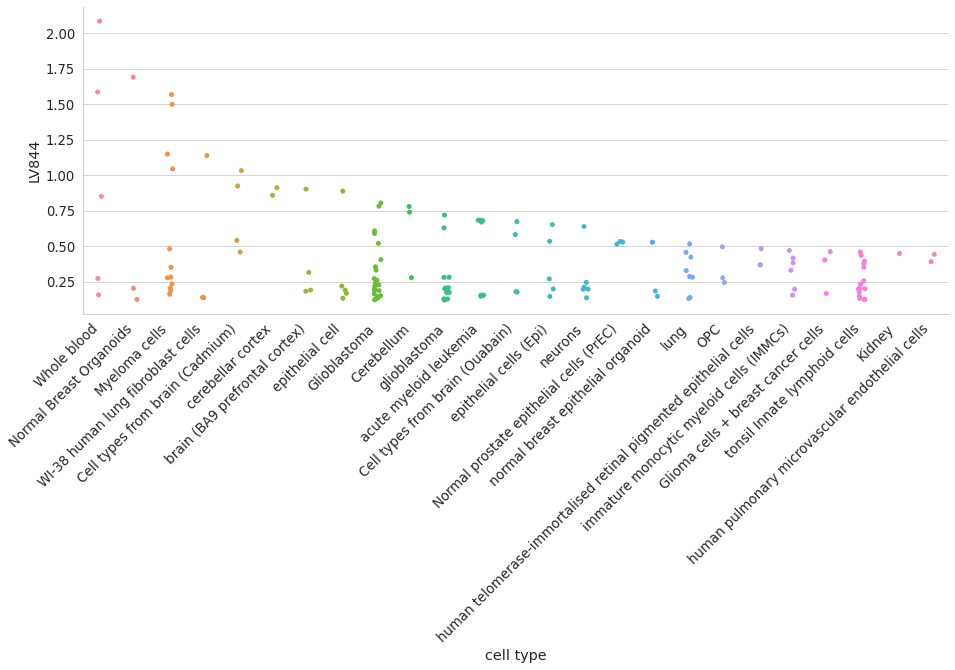

In [42]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [43]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [44]:
# # what is there in these projects?
# lv_data.loc[["SRP050499"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)